# Basic ML Concepts and Ideas

## Overview

  1. More about our basic MNIST-themed binary classifiers
  2. A Tour of General ML Concepts and Terminology

## More about our MNIST classifiers

The simple "digit-8 recognizer" we built contains a few fundamental ideas that are ubiquitous, and hence useful to understand thoroughly - but we so far only justified them somewhat superficially as "plausible choices". Let us try to understand these more deeply.

The trainable classifier we built only has $14\times 14+1$ model parameters - and rather limited performance. We will see later how to get better performance out of training models that can capture more complex high-dimensional structure via admitting nonlinearities.

Before we go there, let's also briefly come back to our "k nearest neighbors classifier" (For more background on this, see: [https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) ). While there are some choices to be made, such as about how many neighbors to take into account, how to scale the dimensions (actual features, or perhaps better feature-percentiles?), and how to weight neighbors, and we could use optimization to fine-tune these, we see that even with ad-hoc choices, this approach has an interesting property: If training set examples are drawn at random and independently from the same distribution as the examples we want to make predictions about, then, "given sufficiently many examples", "we ultimately could learn every structure that there is in high dimensional space". The number of examples needed to do this might be prohibitively large, but in principle, at some point, no matter what we see, we will have seen a few very similar training examples to use as a reference for our decision. Other approaches to learning then are, in a way about "using extra structural properties of the training examples in a clever way to be more resource-efficient in terms of how many examples we need". But as a first question when evaluating a ML application or proposal, it often makes sense to ask: "Could a k-nearest-neighbors classifier do this at least in principle, with very many training examples?"

The idea behind this approach resembles the design of "case law" - "make decisions in alignment with what was done on a closeby other example".

This clearly differs from human intelligence, and in ML, there is the technical term "transfer learning" (See e.g.: [https://en.wikipedia.org/wiki/Transfer_learning](https://en.wikipedia.org/wiki/Transfer_learning)) to describe a higher-level objective: Can a ML system generalize to examples beyond the training set distribution? For many architectures, the answer is "No" - a ML system may be able to learn to approximate the shape of a sine function over those 20 oscillations represented in the training set, but when asked to extrapolate beyond that range, would typically "just shoot off at random", demonstrating no "knowledge of the essence of an oscillation".

For practical applications, when using a k-nearest-neighbors approach, one often finds that using a fixed-but-essentially-random projection down to lower dimensions will retain much of the higher-dimensional probability density lumping/clustering properties while making the problem overall easier to manage.

Let us study those pieces of our optimization-based digit-8 classifier we have not discussed in detail yet "back-to-front", i.e. starting at the output side.



### The Loss Function

For a given choice of parameters, we compute a score that somehow tells us "how well our classifier performs on the training set". Interestingly, we never actually use that score for anything relevant! We only use the gradient of that score-function to minimize, and a more primitive minimizing method, such as "iteratively taking a small step along the direction of the gradient" would work as well. (Subtle detail: The gradient is a co-vector, so "taking a step along the gradient direction" is a fishy concept if we lack a way to convert a co-vector to a vector, i.e. some scalar product. We will come back to this.) So, in a way, one important role of this quality-of-prediction-score is to ensure (via ${\rm rot}\;{\rm grad}\;\phi=0$) "that the steps we take to improve performance won't make us run in circles". If we want to report the quality of the trained model, we generally would want to refer to other figures of merit - and in particular, since we want to use it for generalization, we want to report quality as measured on some test set.

But still - what does this quantity represent? If the label of a given training example $y$ is 1 ("positive case") or 0 ("negative case"), this example contributes $-y\,{\rm log}\,p-(1-y)\,{\rm log}\,(1-p)$ to the objective function we want to minimize, where $p$ is our classifier's best estimate for "probability for this example to be a positive case".

One somewhat intuitive-and-also-quantitative way to think about this is based on a coding theory interpretation. As we will see, "this quantity measures the number of bits, in a proper continuous way, needed to encode the actual labels given the predictions of the classifier", or, to say the same thing in slightly different terms, "a quantitative measure (in bits) of the amount of correction needed to get from the classifier's output to the desired target 'message'".

Let's approach this idea in small steps. Suppose we have an 'Alphabet' consisting of only 4 symbols, A, B, C, D (if you prefer, feel free to call these, for example, C, T, A, G). We want to communicate very long messages made of random uncorrelated sequences of these four letters. How many bits do we expect to need for a 100-letters message?

It actually depends on the probabilities with which each of these letters show up. If probabilities are 1/4-1/4-1/4-1/4, we can simply encode every letter with two bits, A=00, B=01, C=10, D=11, transport the message, and only need 200 bits. We can always do that, irrespective of probabilities, so we will never need more than 200 bits. But sometimes, we can do better. Obviously, "if C and D never show up", i.e. probabilities are 1/2/-1/2-0-0, we can simply encode A=0, B=1, and get away with 100 bits. Furthermore, "if no other letter than A ever shows up", there is "no surprise whatsoever", we know what a length-N message must look like, and we need 0 bits.

Now, how about a situation where probabilities are 1/2-1/4-1/4-0? Half the letters are A, and 1/4 are B, another 1/4 are C, and D never occurs? We have seen that we should use 1 bit to encode a p=1/2 letter, and 2 bits to encode a p=1/4 letter - and indeed, we can un-ambiguously decode a message that uses this encoding scheme: A=0, B=10, C=11.
This uses $\sum_i p_i {\rm log}_{1/2} p_i = 0.5\cdot 1+0.25\cdot 2+0.25\cdot 2+0=1.5$ bits per letter, so we would expect to need 150 bits for a 100-letter message. And we know we cannot do better than that. This is the idea behind "Huffman Coding". (The information content is called "entropy", and this is the same "entropy" as in statistical mechanics, and if the rumor is true that von Neumann proposed the term "entropy" somewhat jokingly, he must have been aware of this. "Number of different messages of that length, given this code" corresponds to "number of realizations of this ensemble" - and the identification carries over to the continuous case. The definitions only differ by a sign.)

Now, what do we do when probabilities do not align so nicely with powers of 2?
Let's say they are 1/3-1/3-1/3-0? We could of course stick with the previous encoding scheme, requiring 1 bit for 1/3 of the letters, and 2 bits for the other cases, for a total of 5/3 bits/letter. There is a way to do better, though: Let us form words made of 5 letters: Each of them has probability $1/3^5=1/243$. With 8 bits, we can discriminate $2^8=256$ cases, so, attributing one 8-bit word per each of these 5-letter words, we even have a few codes to spare. (In a practical scheme, we might perhaps want to use of the extra 5 codes to express "end of message, and the previous word needs to be trimmed after 1,2,3,4,5 letters".) So, amortized, we get 8 bits / 5 letters = 1.6 bits/letter, which is somewhat better. Of course, we could look for even longer words, where $3^n/2^m$ comes closer to an integer (from below), such as encoding 41-letter words with 64-bit sequences for 1.585 bits/letter. The limit is, of course, ${\rm log}_{2}\,3\approx1.5849625$ bits/letter.

Now, is there another perspective on this that readily generalizes to cases where probabilities are not nice fractions such as $1/2, 1/3, 1/4$? Given that we are talking about tunable models, we ideally would want to have a perspective where no probability is really special?

Such a perspective does indeed exist, and is known as "arithmetic coding" (see [https://en.wikipedia.org/wiki/Arithmetic_coding](https://en.wikipedia.org/wiki/Arithmetic_coding)). Technically speaking, this is not quite 100% true, since implementations of AC generally contain one deviation from the "pure" idea to make them practical, but basically, the idea is that we can map a long message that uses an alphabet with given letter-probabilities to a small sub-interval of the unit interval $[0, 1)$ as follows: We first partition this interval according to per-letter probabilities, in our 4-letter case, $[0, p_A), [p_A, p_A+p_B), [p_A+p_B,p_A+p_B+p_C), [p_A+p_B+p_C, 1)$. The first letter selects one of these intervals. We then partition the selected interval with the same proportions, and use the 2nd letter to select a sub-interval, and-so-on. At the end of our message, long as it may be, we have a small interval remaining that contains all real numbers which we could take as valid representations of this message. If $b$ is an integer such that $1/2^b$ is smaller than the length of this interval, then this final interval is guaranteed to contain an integer multiple $m$ of $1/2^b$, with $0\le m\lt2^b$, and this way, we can encode our message with $b$ bits. In the limit of very long messages, we need ${\rm log}_{1/2}\, p_X$ bits to encode a letter $X$ with probability $p$.

So, if sender and receiver have a shared collection of to-be-classified examples, and access to the same (trained) classifier, and the sender also knows the "ground truth" classifications and wants to transmit that information via a compactly encoded message, it would only need to send corrections/amendments to the classifier's output. Let us study a hypothetical case.
We encode a "Yes" as "picking the left part of a subdivided interval".

  * Example 0 has ground truth label "Yes", and shared classifier says:
    "$p({\rm Yes})=80\mbox{\%}$".

    Sender narrows the [0, 1)-interval to [0.0, 0.8).

  * Example 1 has ground truth label "No", and shared classifier says:
    "$p({\rm Yes})=50\mbox{\%}$" (i.e. classifier says "I have a hard time
    saying anything here").

    Sender narrows the [0, 0.8)-interval to [0.4, 0.8).

  * Example 2 has ground truth label "No", and shared classifier
    is rather confident, saying "$p({\rm Yes})=0.1\mbox{\%}$".

    Sender narrows the [0.4, 0.8)-interval by shaving off $0.1\mbox{\%}$ of
    the range at the lower end, to [0.4004, 0.8).

  * Example 3 has ground truth label "Yes", but the shared classifier
    somewhat confidently thinks otherwise, telling us "$p({\rm Yes})=10\mbox{\%}$".

    Sender narrows the [0.4004, 0.8) range down to [0.4004, 0.44036).

  * Example 4 has ground truth label "No", and the shared classifier is
    leaning towards a "Yes", telling us "$p({Yes})=75\mbox{\%}$"

    Sender narrows the [0.428372, 0.44036) range down to [0.43037, 0.44036)

  * We are out of examples. The sender sees that the final interval has length
    $\approx 1/100.1$ and sends the 7-bit binary number
    (most significant bit first) 111000, which represents 56/128=0.4375
    and lies in the final interval.

  * Receiver classifies example 0, gets "$p({\rm Yes})=80\mbox{\%}$" (like sender),
    sees "The number 0.4375 is in the [0, 0.8) sub-interval", infers
    "label=Yes", narrows the interval to [0.0, 0.8).

  * Receiver classifies example 1, gets "$p({\rm Yes})=50\mbox{\%}$", sees
    "The number 0.4375 is in the right half of the 50-50 split of the
    remaining interval", infers "label=No", and narrows the interval
    to [0.4, 0.8).

  * ...and-so-on.

Nicely, we can directly convert the length of the remaining interval to a number of bits by a continuous and smooth function: $b={\rm log_{1/2}} p$. Adding a letter shrinks interval-length multiplicatively, but affects the logarithm additively, so it makes sense to talk about "expectation value of the logarithm of the final interval's length" - this then is the "alphabet(/code)'s entropy times message length".

Now, what happens if we use "number of bits (as measured in the arithmetic-encoding way)" - if you want so: a quantitative measure of the "surprise" - to measure quality of the predictions of our ML model? (The overall factor to convert between ${\rm log}_2$ and ${\rm log}_e$ is if course irrelevant for minimization.) At first, the largest contributions may well come from cases where the classifier accidentally expresses confidence but is off. Here, gradients pull it towards "I should not be so sure about this case". Fine-tuning a "I can even be more certain about this case" situations contributes less - if a classifier can go from "99% certain about this case" to "99.9% certain" and is right with its assessment, this merely changes the interval-length by a factor of about 1.0091, removing 0.013 bits of "surprise".

Conceptually, this "loss function", which is called "cross-entropy" is some sort of "distance between probability distributions" (but a non-symmetric distance, $d(A,B)\neq d(B,A)$ in general - we will come back to it). The same construction is also used to answer the question "how many bits extra do we expect to expend when encoding a random-letters message where the letters follow probability distribution A using a coding scheme as if they followed probability distribution B" - and in this context, it is called "relative entropy" or also "Kullback-Leibler divergence" (see: [https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)).

Naturally, we expect properly set up and trained models to be "calibrated"
in the sense that if we take 1000 test examples for which a binary classifier gives us a probability for the example to carry a positive label in the range 60%-61% to have a positive-examples fraction of 60%-61% (of course then also with sampling noise). It might be that our first classifier is too simple to behave that way, but calibration is in general a useful canary to check that can flag up problems early.

Unfortunately, with the advent of "deep learning" architectures and the focus-shift to "better performance on simple metrics such as classification accuracy makes work publishable", proper model calibration is no longer what one can usually expect.

See Figure 1 of [https://arxiv.org/pdf/1706.04599.pdf - On Calibration of Modern Neural Networks](https://arxiv.org/pdf/1706.04599.pdf).

### The Logistic ("sigmoid") Function

The other question is why we use the "sigmoid function" $x\mapsto\frac{1}{1+\exp(b-x)}$ (effectively the Fermi-Dirac distribution function $\mu\mapsto\frac{1}{1+\exp(\beta(E-\mu))}$) to obtain probabilities.

At a simplistic level, "we want to map evidence to probability, and probabilities are in the range [0, 1]", so we should use a function
with range such as ${\mathbb R}\to(0, 1)$, and the sigmoid fits that bill. There is however a deeper reason.

A nice example that provides some useful background here is email SPAM filtering. (SPAM = unsolicited commercial email.) While the questions "why this problem exists at all" and also "whether automated spam filtering actually is a meaningful approach" very much are worthwhile to discuss, we want to concern us with a different aspect: If we wanted to do automated spam detection - how could one build a useful classifier?

Until about 2002, email SPAM filtering was dominated by hand-crafted and curated spam detection rules. This changed in 2002 with an online article by Lisp Hacker and writer Paul Graham ([http://www.paulgraham.com/spam.html - A Plan for Spam](http://www.paulgraham.com/spam.html)). In hindsight, the reason this article exists is that the author was not aware of earlier - flawed - research that looked into this approach and found it to not work. The gist of Paul Graham's idea is that we should try a "naive Bayesian" approach, look for simple signals in favor and also against a given email message to be SPAM, and then combine these signals into a spam-probability. Interestingly, in 2002, the rather crude model proposed by Paul Graham did indeed work very well - so well indeed that it was widely adopted and led to a wave of very weird-looking SPAM that tried to trick classifiers based on this idea. But what, then, was the idea? Basically:

  1. If we have a somewhat large corpus of personal email messages
     labeled as "SPAM", respectively "not-SPAM", it is simple to build
     a lexicon out of the dictionary words in all these messages and
     estimate, per-word, what the likelihood is for an email containing
     this word to be SPAM. (Different people's mailbox may give very
     different-looking such dictionaries. The term "supergravity" is generally
     not present in most people's mailboxes, and where it is, it generally
     is strong "not SPAM" evidence - while the term "prince" may
     well provide SPAM evidence for most people.)
     
  1. We bluntly treat all SPAM-relevant words as "independent experts".
     Suppose an email message contains only two SPAM-relevant terms, A and B,
     and we have "$p_A$={probability estimate for an email message
     containing the term A to be SPAM}," as well as "$p_B=${probability
     estimate for an email message containing the term B to be SPAM}".
     What is then a good probability estimate for the email to be SPAM
     if these simple-to-compute "experts" were independent
     (which, of course, is a very crude and doubtful assumption).

Let's say we have a large body of email messages that have been sampled in such a way that half of them are SPAM. A small fraction $q_A$ of these messages contain the term A, and an independent small fraction $q_B$ of these messages contain the term B. We determine $p_A$ and $p_B$ as above. Now, on the fraction $q_A\cdot q_B$ of email messages that contain both the term A and B, some are SPAM and some are not SPAM. The relative sizes of these fractions are $p_A\cdot p_B$ and $(1-p_A)\cdot(1-p_B)$, so the SPAM probability among these messages is $p_{AB}=\frac{p_Ap_B}{p_A p_B+(1-p_A)(1-p_B)}$. So, we have the following binary function `$C:{\mathbb R}\times{\mathbb R}\to{\mathbb R}$` for combining probabilities:
$$
  C(a, b)=\frac{a\cdot b}{a\cdot b + (1-a)\cdot(1-b)}.
$$

Naturally, we have $C(b, a)=C(a, b)$, as well as $C(a, 0.5)=a$ and also $C(C(a, b), c)=C(a,C(b,c))$ - and as we would expect from this motivation, a bit of algebra gives us $C(C(a, b), c)=\frac{a\cdot b \cdot c}{a\cdot b\cdot c+(1-a)\cdot(1-b)\cdot(1-c)}$.

Now, this structurally resembles a situation we know well from special relativity: the relativistically correct formula for adding collinear velocities (using $c=1$) is $s(v, w)=\frac{v+w}{1+vw}$, and we also have commutativity, associativity, and a neutral element. For relativistic velocities, we know that the story simplifies a lot if we regard velocities as "dressed up other quantities" which just can be added linearly. These "other quantities" we call "rapidities", and the dressing/undressing is done by
$u={\rm tanh}^{-1}\,v$, respectively $v={\rm tanh}\,u$.

So, is there a corresponding pair of a dressing/undressing function that trivializes our "addition function" $C(a, b)$ above - making `C(.,.)` merely dressing-up a sum after un-dressing the summands? Our neutral element is $p_A=0.5$, and this should correspond to "evidence zero". (Clearly, adding another independent expert who merely flips a fair coin does not help or hurt us with any classification task.) Let us call our (not yet known) evidence-to-probability function $P:{\mathbb R}\to(0, 1)$.
We know that $P(0)=0.5$ holds. Also, we expect $P$ to be smooth. Let us define $P'(0):=\gamma$, so that we have an expansion $P(\epsilon)=0.5+\gamma \epsilon+{\mathcal O}(\epsilon^2)$. Since we want
$P(x+y)=P(x)P(y)/(P(x)P(y)+(1-P(x))(1-P(y))$ to hold, we can use this to
expand $P(x+\epsilon)$ to 1st order in $\epsilon$ and derive the differential equation $P'(x)=4\gamma P(x)(1-P(x))$.

So far, $\gamma$ is an arbitrary slope-paramter. We naturally would want $\gamma\lt 0$ ("more positive evidence increases the probability"), but its value basically is merely about picking some nice normalization on the evidence-scale (like "setting $c=1$" for special relativity). Here, a natural choice is $\gamma=1/4$, and with this we get the ODE $P'=P(1-P)$.

The next steps are straightforward: Let us define $Q(x):=1/P(x)$, which gives us $Q'/(Q-1)=-1$, so ${\rm log}\,(Q(x)-1)=-x+c$, and from this we find (for $\gamma=1/4$, and also using $P(0)=0.5$):

$$P(x)=\frac{1}{1+\exp(-x)}$$.

In the context of statistics (or ML), this is called the "logistic" function. Its inverse is the "logit" function:

$$P^{-1}(p)={\rm log}\frac{p}{1-p}=2\,{\rm tanh}^{-1}(2p-1)$$.


### Multiclass classification

While we now fully understand every aspect of the construction of our simple digit-classifier, there is one detail left to look into: So far, we discussed a simplified "binary classification" setting. How about 1-in-10 classification? We could of course train 10 binary classifiers ("this vs. everything else"), and then somehow try to merge these. In terms of fundamental properties, what would we expect the "loss function" to look like? Important desiderata are:

  * We still want to be able to map some
    "(linearly) accumulated independent (per-class) evidence"
    to (per-class) probability.

  * Using relative entropy / KL divergence as the objective function still
    seems to make sense. For the "correct" label, we get a contribution of
    $-{\rm log}\, p_i$, and for each incorrect label, $-{\rm log}(1-p_k)$.

  * We again would like to have some simple "naive Bayesian" interpretation
    to hold. To give a simple example, for two independent 1-out-of-3
    classifiers that see evidence-vectors (of independent evidence)
    $(e_{1A}, e_{1B}, e_{1C})$, respectively $(e_{2A}, e_{2B}, e_{2C})$,
    and attribute to these the corresponding probability-vectors
    $(p_{1A}, p_{1B}, p_{1C})$, $(p_{2A}, p_{2B}, p_{2C})$, we would
    like identities such as this one to hold:

    $$
     p_{(1+2)A} = \frac{p_{1A}p_{2A}}{p_{1A}p_{2A}+p_{1B}p_{2B}+p_{1C}p_{2C}}
    $$
    In words: combining the assessments from both independent experts,
    out of all examples that expert 1 attributes probabilities
    $(p_{1A}, p_{1B}, p_{1C})$ to, and expert 2 attributes probabilities
    $(p_{2A}, p_{2B}, p_{2C})$ to [fine print: where these probabilities
    are representative for some chunk of probability-space],
    the relative odds for "true label is A" : "true label is B"
    are $p_{1A}p_{2A}:p_{1B}p_{2B}$, and likewise for the other
    two combinations.

If we want probabilities to behave multiplicatively when we add independent evidence, this means that the probability-ratio for two classes $p_A:p_B$ should be given by the exponential of the evidence difference: $p_A:p_B=\exp(e_A-e_B)$. This then gives us these probabilities:

$$
(p_A, p_B, p_C) = (\exp(e_A)/Z, \exp(e_B)/Z, \exp(e_C)/Z),\;\;{\rm with}\;Z:=\exp(e_A)+\exp(e_B)+\exp(e_C).
$$

Or, for $N$ classes:

$$p_i=\frac{\exp e_i}{\sum_k \exp e_k}.$$

[**Participant Exercise**: Show that in the case of binary classification, this indeed reduces to the logistic function.]


This function, called "softmax" in a Machine Learning context, is of course just the Boltzmann distribution. Intuitively, there is little surprise to the physics-trained eye here (perhaps depending on how much of a physical chemist one is). If we think of an individual example's total classification-probability as some kind of molecular substance where each individual molecule can be in one out of multiple discriminable but energetically-equivalent configurations (each configuration corresponding to a ML label class), then the thermodynamic-equilibrium proportions of the different configurations (ML perspective: per-class probabilities for the example) would be determined by the chemical potential. In this picture, the accumulated per-class-evidence plays the role of a "chemical potential" (up to a sign).


### More about the ("pedestrian"-)thermodynamics interpretation

Suppose we build an image classifier that can discriminate three types of fruit: apples, oranges, and bananas. Let's say that for each type of fruit, there is a hidden "internal" classification system that an expert on the fruit could use to discern three independent describing attributes, such as "variety" (with, say, 5 options per fruit-type),  "ripeness" (typically going from "still green" to "green once again" - let's say also with 5 options), and "imperfections" (also with 5 options).

Now, let's say the probability for each combination of
`(fruit-type, fruit-variety, fruit-ripeness, fruit-imperfections)` is the same according to the distribution from which we draw our examples.

What happens if our ML-classifier, when analyzing an example, extracted a feature that could be described in approximate-human-terms as "this fruit has a brown spot"? Let's say two of the five imperfection-categories for bananas and apples are compatible with "brown spot observed", but only one for "oranges". Then, this one feature-observation opens up a one-of-two-choices degree of freedom for apples and bananas, but we only have a one-of-five-choice for oranges. Then, there are twice as many ways how the observations could be compatible with "we are looking at an apple" in comparison to "we are looking at an orange". Likewise for banana-vs-orange. So, the "space of possibilities" has acquired a relative factor 2 each for two fruit types, and "evidence", which should be a linear additive quantity measuring the space of options (like entropy) hence should increase by the log of that factor. Knowing nothing else, having observed a brown spot overall makes it less likely that we are looking at an orange, but this is of course a pure gambler's argument that does not involve any "understanding" whatsoever.

Now, let us compare this to a pedagogically-constructed chemical situation. Suppose we have a gas of 5-atomic molecules, a carbon-12 "stereocenter" in the middle and four different atoms around it - let's say F, Cl, Br, I. Each molecule can be in left-handed ("S") or right-handed ("R") configuration. Let's say we also provide a catalyst that allows removing and reattaching an I-atom, and when reacting with the catalyst, the left-handed form can turn into the right-handed form and vice versa. Furthermore, let's assume each of these odd-number-of-protons nuclei had a total nuclear spin of 1/2. Then, focusing on nuclear spin, we could describe that part of the quantum state of such a molecule as an element of a 2x2x2x2-dimensional Hilbert space, one dimension per nucleus. If we started from 100% left-handed molecules, interaction with the catalyst would get us into an equilibrium that is a 50%-left-50%-right mixture. Now, suppose we had some "thermodynamic daemon" type magical catalyst which, whenever a left-handed molecule gets turned into a right-handed one, it replaced the iodine atom with one that has nuclear spin zero, and replaced the spin-zero iodine on a right-handed molecule with a spin-1/2 one as it gets turned into a left-handed molecule again? Then, the nuclear-quantum-state Hilbert space for the right handed form would be 2x2x2x1-dimensional, "having one degree of freedom less". In terms of "logarithm of the size of the space of opportunities", there is a log(2)-difference between these cases, and this then is the contribution to the chemical potential that favors the "more configurations available" left handed form. Going back from chemical potential to probabilities, we exponentiate that difference again, and get a
2/3-left-to-1/3-right ratio, which we can attribute to "left form having one degree of freedom more".



# Some Concepts and Terminology

We built a rather simplistic "logistic regression based" handwritten digit classifier. Before we explore how to improve this, we should look into some concepts and terminology that allow us to form an idea of what "classifier A performs better than classifier B" means.

For a simple benchmark problem such as "handwritten digit classification" where each digit is equally likely[1], a very basic performance metric, measured on some "test set" that was set aside so that it could not possibly have affected decisions entering the design or training of the classifier, is **accuracy**, i.e. the fraction of correctly classified examples. This, however, can be misleading, especially...

 * ...if some mis-classifications are substantially more painful than
   others, and also
 * ...if there is substantial class imbalance, such as: "99% of examples
   are Negative anyhow".

[1]: Note however that among actually-handwritten-by-people digits, we likely would see more 1-s than 9-s.(See: https://en.wikipedia.org/wiki/Benford%27s_law).

---

Let us first focus on some terms related to **binary classification** tasks. The difference between "type I error" and "type II error" is commonly discussed in secondary education: A "type I error" is a "False Positive" - "we cry wolf but there is no wolf". A "type II error" is a "False Negative" - "we fail to cry wolf but should have". Overall, we have:

  * True Positive Fraction (TP) - fraction of true positives
    (ground truth label = yes; classification = yes) in the example set.
  * True Negative Fraction (TN) - fraction of label=no, classification=no.
  * False Positive Fraction (FP) - fraction of label=no, classification=yes.
  * False Negative Fraction (FN) - fraction of label=yes, classification=no.

In terms of these, "accuracy" is TP+TN, i.e. the fraction of correctly classified cases. We also define "recall" as "fraction of label=yes examples we manage to classify as positive", i.e. TP/(TP+FN), as well as "precision" as "fraction of label=yes examples among those we classify as positive", i.e. TP/(TP+FP). There are other - derived - metrics such as F1-score, which are however less commonly reported.

In general, for binary classification tasks, our classifier will produce some sort of "confidence" for a classification, and with proper calibration, this may take the form of "I am 80% confident this is a Yes". We would then expect about 20% of all those example to which a (properly calibrated!) classifier attributes a probability in the interval $[80\%-\epsilon, 80\%+\epsilon]$ to actually be negative cases.

We obviously have a choice of a threshold here: Do we want to play it safe and only classify examples as "yes" where the classifier is $\ge 99\%$ certain of that classification, accepting that we will miss some positive cases, or do we want to catch as much as we can, classifying even "slightly suspicious cases" as "interesting (such as: for subsequent investigation)" as "positive", perhaps using even a threshold of only $1\%$ - or something in between?

Let us consider a fixed set of labeled examples and see what happens if we start from a threshold of $100\%$ and gradually lower it.

Each example has been given a score by the classifier, and all that matters is the ordering of examples by score, and what happens when lowering the threshold crosses the score of the next example. These properties are invariant under mapping classifier score to some other score as long as we use a strictly monotonically increasing mapping.

For thresholds higher than the maximal example score, we classify nothing as positive, so have TP = FP = 0.

For thresholds lower than the minimal example score, we classify everything as positive, and have TP = FP = 1.

What happens if we start at high threshold, TP=FP=0 and keep lowering the threshold? We keep crossing examples which change their classification from "negative" to "positive". If the label was "positive", this increases TP
by 1/{number of positive examples}. If the label was "negative", this increases FP by 1/{number of negative examples}. So, we either take a small step in +x or in +y direction on the (x=FP, y=TP) plot.

If the "classifier" just randomly guessed scores, and we have a fraction p of positive examples, then at every score-crossing, we will, with probability p, take a step of size 1/p in y=TP direction, and with probability 1-p take a step of size 1/(1-p) in x=FP direction. So, the TP/FP-for-all-thresholds
curve will be a "noisy diagonal line". One relevant metric is ROC-AUC, the "receiver operating characteristic area-under-curve". Here, the TP/FP-curve just described is called the "receiver operating characteristic" (ROC). This is a threshold-invariant measure of classifier performance. For a good-quality classifier, we expect that lowering the threshold starts catching many correctly-classified examples, so TP should go up with FP ideally only increasing a little - while for low thresholds, we ultimately also mis-classify all negative examples as positive, and the curve reaches (x=TP=1, y=FP=1).

The ROC-AUC can be interpreted directly as the probability for a randomly picked positive-label and negative-label example to have classifier-scores "in good order", i.e. positive-label example has higher score than negative-label example. This is so for the following reason: If we lower the threshold until we make the next False-Positive mis-classification, we move a stretch of 1/(1-p) along the x=FPR axis, at y=TPR-at-this-new-threshold. So, to each negative example, we can attribute a rectangle on the graph that measures the fraction of positive examples among all positive examples which have a score lower than this one.

Details and plots can be found on: [https://en.wikipedia.org/wiki/Receiver_operating_characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

## A DL Classifier "from scratch"

Let us see if we can build a full-fledged "Deep" Neural Network based handwritten digit classifier entirely from scratch (only a few hidden layers, mostly to illustrate the key ideas).

This is indeed feasible, but we need to look into a few tricks.

Pre-DL, the situation was that, even if we managed to train a fully-connected deep neural network with more than 2, perhaps 3, layers, this generally would not have managed to add any benefit. Nowadays, we know how to even get performance improvements from extra layers at 100+ layers deep.

Why do this "from scratch"? As physicists, "we understand what we can create", and we may sometimes find ourselves in a situation where we want to make changes to something that just about every ML framework would not allow us to change.

What is the basic idea behind "deep learning" architectures? So far, we have built a simple logistic regression classifier, "where every pixel was an input feature". We could consider improving this by adding "feature products", i.e. also add tunable weights for products-of-intensities-of-two-pixels. We might want to simplify this by first performing a (tuneable) linear projection from $N\times N$ pixels to some $D$-dimensional space, $D\ll N\times N$, and then
taking our features from perhaps $D\oplus D\otimes D\oplus D\otimes D\otimes D\oplus\ldots$ - and this would indeed "allow learning to become sensitive to more complicated high-dimensional distribution structure".

Depending on the problem, we might even hand-craft some of the features, perhaps after doing extensive research on "where the evidence sits". Such "feature engineering" was an important part of pre-DL ML, and a common situation was that ML turned out to be "merely a tool to guide problem analysis, and once we understand the problem, it falls apart and we see how to do this without using ML".

Post-DL-revolution, the question of which model architectures (/ architecture elements or ideas) are especially useful for which types of problems is still relevant, but the focus has shifted away from engineering extraction of individual features. Often, we are in a situation where "the entire tree gets pushed in on one side, and a table comes out on the other side, and we can leave it to ML training to figure out on its own what part is useful to make what part of the result."

For handwritten digit classification, making this possible is mostly about avoiding some earlier mistakes.

The basic architectural choice for this exercise will be a rather simple fully connected Neural Network, where each layer has a certain number of units each of which receives a trainable linear combination of the outputs of the previous layer as input, and applies a simple nonlinear-but-differentiable ${\mathbb R}\to{\mathbb R}$ function to this linear combination to produce its output.

Specifically, let us use these tricks (there are a few more which we will, for now, deliberately ignore):

  * We normalize our input-vectors such that features have mean zero
    and variance 1.
  * We use many training examples (tens of thousands).
  * We use a blunt approach to fast training ("stochastic gradient descent"):
     * Estimate, rather than compute, the training set loss
       (rather, its gradient) by only considering a small
       random sample of all training set exercises (such as: 32)
       for each parameter-update.
     * Multiply the
       $\partial(\mbox{loss})/\partial(\mbox{parameter k})$-gradient
       with a small (negative) step-size, the "learning rate", and update
       parameters by walking in that direction.
  * We pay some attention to random parameter-initialization,
    the basic idea being: "If for every input, activations are roughly
    normal-distributed, this should also hold for every output -
    if inputs are independent."

This then leads us to the code shown below - here, for the last time, with hand-crafted backpropagation.

For this example, we will need some nonlinearity. The actual choice does not matter too much, but let us pick a function that is symmetric around zero, has a near-zero linear region where it is approximated well by the identity, stays very roughly linear for a value of up to about 1 or so, has a somewhat simple analytic derivative, and does not flatten exponentially, so further-out regions still do contribute somewhat to gradients. One function that fits the bill here is the inverse tangent (arctangent) function.

In [ ]:
# Importing the relevant Python libraries ("modules").
import math
import pprint
import time

import matplotlib
from matplotlib import pyplot
import numpy
import scipy.optimize
import tensorflow as tf

# Larger figures.
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [ ]:
def get_nn_classifier_func(parameters=()):
  """Returns a neural network classifier function.

  Args:
    parameters: A sequence of 2-index numpy.ndarray-s `wb`, each of shape
      [layer_width + 1, next_layer_width] that represent the weights
      (indexed `wb[input_node_index, output_node_index]`) and biases
      (indexed `wb[layer_width, output_node_index]`) for the inter-layer
      connections.

  Returns:
    A function `f` with signature
    ```def f(batch_features, batch_labels, want_gradient=False):
         ...
         return loss, softmax_probs, opt_grad_param_pieces
    ```
    where `batch_features` is a [batch_size, num_features] numpy-array-like
    value providing batch-features (which will internally get converted
    to a numpy array), `batch_labels` is a [batch_size, num_classes]
    numpy-array-like value providing per-example labels in one-hot encoded
    form, batch-indexed in parallel to `batch_features`, and `want_gradient`
    determines whether gradients should be computed. If this is logically
    false, the `opt_grad_param_pieces` part of the returned tuple is None,
    otherwise it is a sequence of numpy-arrays indexed in parallel to
    `parameters` which provides the corresponding gradient-component
    of the loss with respect to the parameters. Correspondingly, the `loss`
    part of the returned tuple is the averaged-across-batch-examples
    cross-entropy loss of the prediction vs. the given labels on the batch,
    and `softmax_probs` is a vector of predicted probabilities.
  """
  def loss_pred_grad(batch_features, batch_labels,
                     want_gradient=False):
    """Runs inference and optionally computes gradients."""
    # Labels must be one-hot!
    batch_features = numpy.asarray(batch_features)
    batch_labels = numpy.asarray(batch_labels, dtype=batch_features.dtype)
    intermediate_data = []
    batch_size = batch_features.shape[0]
    num_classes = batch_labels.shape[1]
    # Per batch-example, turn input features into a vector.
    activations_now = batch_features.reshape(batch_features.shape[0], -1)
    for num_layer, layer_params in enumerate(parameters):
      weights = layer_params[:-1, :]
      biases = layer_params[-1:, :]
      pre_nonlinearity = numpy.einsum('bi,io->bo',
                                      activations_now,
                                      weights) + biases
      if num_layer + 1 != len(parameters):
        post_nonlinearity = numpy.arctan(pre_nonlinearity)
      else:
        # No activation on final layer, which inputs into softmax.
        post_nonlinearity = pre_nonlinearity
      intermediate_data.append((activations_now,
                                pre_nonlinearity,
                                post_nonlinearity))
      activations_now = post_nonlinearity
    # We still have to convert the final activations to probabilities --
    # which we do via softmax. We use a trick to avoid large arguments
    # to exp(), shifting all activations to max=0.
    max_activation_indices = activations_now.argmax(axis=-1)
    max_activations = numpy.fromiter(
        (example[k] for example, k in zip(activations_now, max_activation_indices)),
        dtype=activations_now.dtype)[:, numpy.newaxis]
    max_activations = activations_now.max(axis=-1, keepdims=True)
    shifted_activations = activations_now - max_activations
    softmax_weights = numpy.exp(shifted_activations)
    softmax_denoms = softmax_weights.sum(axis=-1, keepdims=True)
    softmax_probs = softmax_weights / softmax_denoms
    entropy_contribs = numpy.where(batch_labels,
                                   -numpy.log(1e-12+softmax_probs),
                                   -numpy.log(1-softmax_probs+1e-12))
    loss = entropy_contribs.sum(axis=-1).mean()  # per-batch-example
    #
    if not want_gradient:
      return loss, softmax_probs, None
    # We want a gradient.
    # Backpropagation code below.
    # [We already know how this works, so this may perhaps be only be of
    #  interest for participants who want to see more code examples. We need
    #  not discuss this in detail. "No really new tricks here."]
    s_entropy_contribs = numpy.full([batch_size, num_classes], 1 / batch_size)
    s_log_softmax_probs = numpy.where(batch_labels,
                                      -s_entropy_contribs, 0)
    s_log_complementary_softmax_probs = numpy.where(batch_labels, 0,
                                                    -s_entropy_contribs)
    # Here, we recompute some simple intermediate quantities which we did not
    # bother to hold on to.
    s_softmax_probs = s_log_softmax_probs / (1e-12 + softmax_probs)
    s_softmax_probs -= s_log_complementary_softmax_probs / (1-softmax_probs+1e-12)
    s_softmax_denoms = -(s_softmax_probs * softmax_weights /
                         softmax_denoms**2).sum(axis=-1, keepdims=True)
    s_softmax_weights = s_softmax_probs / softmax_denoms
    s_softmax_weights += s_softmax_denoms
    s_shifted_activations = softmax_weights * s_softmax_weights
    s_max_activations = -s_shifted_activations.sum(axis=-1)
    s_activations_now = s_shifted_activations
    # This step is a bit messy - we here have to do in Python what ought
    # to be handled in NumPy.
    for num_example, k in enumerate(max_activation_indices):
      s_activations_now[num_example, k] += s_max_activations[k]
    # Here, `s_activations_now` are the sensitivities on the final inputs
    # to softmax.
    grad_param_pieces = [None] * len(parameters)
    for num_layer_transition in reversed(range(len(parameters))):
      k = num_layer_transition # Abbrev.
      s_post_nonlinearity = s_activations_now
      activations, pre_nonlinearity, post_nonlinearity = (
          intermediate_data[num_layer_transition])
      if num_layer_transition + 1 != len(parameters):
        s_pre_nonlinearity = s_post_nonlinearity / (
            1 + numpy.square(pre_nonlinearity))
      else:
        s_pre_nonlinearity = s_post_nonlinearity
      # Forward code was:
      # weights = layer_params[:-1, :]
      # biases = layer_params[-1:, :]
      # pre_nonlinearity = numpy.einsum('bi,io->bo',
      #                                 activations_now,
      #                                 weights) + biases
      layer_params = parameters[num_layer_transition]
      weights = layer_params[:-1, :]
      biases = layer_params[-1, :]
      s_layer_params = numpy.zeros_like(layer_params)
      # Bias-sensitivities.
      s_layer_params[-1, :] += s_pre_nonlinearity.sum(axis=0)
      s_layer_params[:-1, :] += numpy.einsum(
          'bo,bi->io', s_pre_nonlinearity, activations)
      s_activations_now = numpy.einsum(
          'bo,io->bi', s_pre_nonlinearity, weights)
      grad_param_pieces[num_layer_transition] = s_layer_params
    return loss, softmax_probs, grad_param_pieces
  #
  return loss_pred_grad



In [ ]:
# Let us first try out a really simple "random" example,
# checking if our gradients work. (They do!)
rng = numpy.random.RandomState(seed=0)
demo_params = [rng.normal(size=(2+1, 5), scale=0.4),
               rng.normal(size=(5+1, 4), scale=0.4),
               rng.normal(size=(4+1, 2), scale=0.4)]
demo_batch_features, demo_batch_labels = (
    rng.normal(size=(3, 2), scale=0.1),
    numpy.array([[0, 1], [0, 1], [1, 0]]))

f_demo = get_nn_classifier_func(demo_params)
f_demo_val, _, f_demo_grad = f_demo(demo_batch_features, demo_batch_labels,
                                 want_gradient=True)
print('f_demo_val:', f_demo_val.round(6).tolist())
pprint.pprint([t.round(5).tolist() for t in f_demo_grad])

def get_numerical_gradient(n, idx1, idx2, eps=1e-6):
  # We are mutating params[n][idx1, idx2] by eps and evaluate the difference.
  demo_params_eps = list(demo_params)  # Copy.
  demo_params_eps[n] = demo_params_eps[n].copy()
  demo_params_eps[n][idx1, idx2] += eps
  f_demo_eps = get_nn_classifier_func(demo_params_eps)
  f_demo_eps_val, _, _ = f_demo_eps(demo_batch_features,
                                    demo_batch_labels,
                                    want_gradient=True)
  print('f_demo_eps_val:', f_demo_eps_val, 'vs.', f_demo_val)
  return (f_demo_eps_val - f_demo_val) / eps

print('###')
print(get_numerical_gradient(0, 0, -1))


f_demo_val: 2.175762
[[[0.0019, 0.0026, -0.01194, 0.01522, -0.01891],
  [-0.00507, -0.00759, 0.03308, -0.04231, 0.05237],
  [0.06119, 0.09462, -0.40677, 0.5206, -0.64192]],
 [[0.02846, 0.01043, 0.087, 0.03194],
  [0.1313, 0.04752, 0.4027, 0.14725],
  [0.08044, 0.02917, 0.24657, 0.09022],
  [0.02027, 0.00746, 0.06195, 0.02275],
  [0.04768, 0.01734, 0.14611, 0.05349],
  [0.25897, 0.09375, 0.79419, 0.29044]],
 [[-0.14684, 0.14684],
  [0.26458, -0.26458],
  [0.27931, -0.27931],
  [0.01699, -0.01699],
  [0.89155, -0.89155]]]
###
f_demo_eps_val: 2.1757617947269394 vs. 2.175761813641268
-0.018914328769881195


In [ ]:
# Let us get the MNIST training set...

import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
)

images_and_labels_all = list(ds_train.as_numpy_iterator())
print('Number of MNIST training-set examples:', len(images_and_labels_all))
# We build our training and test set from the MNIST "training" examples.
# (If we used the `test` examples in any way here, we would risk making
# decisions about our model based on official test set performance,
# hence end up "training on the for-evaluation test set". We must avoid this!)
#
# ...but let us shuffle them randomly-but-reproducibly.
rng = numpy.random.RandomState(seed=0)
rng.shuffle(images_and_labels_all)
num_training = 4 * len(images_and_labels_all) // 5  # 80% training examples.
images_and_labels_training = images_and_labels_all[:num_training]
images_and_labels_ourtest = images_and_labels_all[num_training:]
print('\n######\n')
print('Number of examples in our training set:', num_training)





Number of MNIST training-set examples: 60000

######

Number of examples in our training set: 48000


In [ ]:
# We need to map the labels to one-hot form.
labels_1hot_all = numpy.zeros([len(images_and_labels_all), 10])
labels_1hot_all[numpy.arange(len(images_and_labels_all)),
                numpy.fromiter(
                    (label for _, label in images_and_labels_all),
                    dtype=numpy.int32)] = 1.0
print('### Labels')
print(labels_1hot_all[:5])

labels_1hot_training = labels_1hot_all[:num_training]
labels_1hot_ourtest = labels_1hot_all[num_training:]

img0_all = numpy.stack(
    [(img.reshape(28, 28) / 255.0) for img, _ in images_and_labels_all],
    axis=0)

img0_training = img0_all[:num_training]
img0_ourtest = img0_all[num_training:]
# We could imagine doing per-pixel-feature input normalization, but this
# would have some problems due to rarely activated pixels. Let us instead
# simply make the mean pixel activation zero and standard deviation 1.
img_offset = img0_training.mean()
img_stddev = numpy.std(img0_training)
img_training = (img0_training - img_offset) / img_stddev

print(img_training.shape)
pyplot.imshow(img_training[0], cmap='gray'); pyplot.show()

# We already shuffled our images. So, we can define batches by merely reshaping
# the arrays.
batch_size = 64
num_batches = num_training // batch_size
num_training_used = num_batches * batch_size
batched_labels_1hot_training = (
    labels_1hot_training[:num_training_used].reshape(
        num_batches, batch_size, 10))

# Our classifier is built in such a way that it reshapes every single
# example's features to a vector anyhow, so we may as well feed them
# in as 28x28.
batched_img_training = img_training[:num_training_used].reshape(
    num_batches, batch_size, 28, 28)

# Let us actually build a first blunt classifier.
rng1 = numpy.random.RandomState(seed=1)
model_params = [
          # First, we (nonlinearly) map pixels to a 25-vector.
          rng1.normal(size=(28*28+1, 25), scale=1/28),
          # Then, this 25-vector to another 25-vector.
          rng1.normal(size=(25+1, 25), scale=1/5),
          # Then, once more.
          rng1.normal(size=(25+1, 25), scale=1/5),
          # Then, to a 10-vector for softmax.
          rng1.normal(size=(25+1, 10), scale=1/5)]

classifier_func = get_nn_classifier_func(model_params)


def train_one_epoch(rng,
                    params,
                    classifier_func,
                    batched_labels,
                    batched_imgs,
                    learning_rate,
                    print_every=200):
  num_batches = batched_labels.shape[0]
  batch_sequence = list(range(num_batches))
  rng.shuffle(batch_sequence)
  for num_batch, batch_index in enumerate(batch_sequence):
    loss, pred, grad = classifier_func(batched_imgs[num_batch],
                                       batched_labels[num_batch],
                                       want_gradient=True)
    if num_batch % print_every == 0:
      print(f'Batch {num_batch:4d} / {num_batches:4d}: Loss={loss:10.3f}')
    for p, delta_p in zip(params, grad):
      p -= learning_rate * delta_p

for num_epoch in range(50):
  print('### Epoch', num_epoch)
  train_one_epoch(rng1,
                  model_params,
                  classifier_func,
                  batched_labels_1hot_training,
                  batched_img_training,
                  1e-4)


In [ ]:
# For a better classifier: Let's train for a bit longer.
# (Feel free to skip this.)

for num_epoch in range(50, 500):
  print('### Epoch', num_epoch)
  train_one_epoch(rng1,
                  model_params,
                  classifier_func,
                  batched_labels_1hot_training,
                  batched_img_training,
                  1e-4)


In [ ]:
# Let us try out our trained classifier on a few examples from our test set.
loss1, predictions1, _ = classifier_func(
    # Need to use the same normalization function.
    (img0_ourtest - img_offset) / img_stddev,
    labels_1hot_ourtest)

pprint.pprint(predictions1[:10].round(2).tolist())
pprint.pprint(labels_1hot_ourtest[:10].tolist())
print(list(
    zip(numpy.argmax(predictions1[:20], axis=-1),
        numpy.argmax(labels_1hot_ourtest[:20], axis=-1))))

# After 500 training epochs, we get an accuracy of ~94.37%.
# Not too great, but somewhat better than what a linear model
# can hope to achieve here. After 1000 epochs, we see an
# accuracy of ~95.10% - the model is still improving with more training.
print('Accuracy:',
      numpy.mean([x == y for x, y in zip(
          numpy.argmax(predictions1, axis=-1),
          numpy.argmax(labels_1hot_ourtest, axis=-1))]))

[[0.97, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.98, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.01, 0.0, 0.98],
 [0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.98],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.99],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0, 0.96],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.97, 0.0, 0.03],
 [0.15, 0.0, 0.05, 0.55, 0.04, 0.01, 0.02, 0.01, 0.16, 0.02],
 [0.0, 0.99, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.99, 0.0, 0.0, 0.0]]
[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0

## Summary

  * We have a basic trainable 'deep NN classifier' for handwritten digits.
  * This setup has many of the important generic elements of a
    fully-connected DNN approach. Some performance-improving
    tricks and tweaks are still missing, though.
    (We can explore quite a few of these via TensorFlow Playground.)
  * Here, we trained a model with more than 20k parameters
    to do something useful, using stochastic gradient descent.

In [ ]:
print('Total trainable model parameters:', sum(m.size for m in model_params))

Total trainable model parameters: 21185


## A Closer Look

Let us explore one specific detail about our current set-up.
Suppose we build a MNIST-classifier much like this, where we use even more hidden layers and all make them same-with, also sticking with our atan-nonlinearity. What do the gradients then actually look like?

In [ ]:
def explore_gradients(num_layers=7,
                      layer_width=30,
                      num_training_epochs=0,
                      learning_rate=1e-4,
                      std_weights_layer0=0.03,
                      std_biases_layer0=0.0,
                      std_weights=0.1,
                      std_biases=0.1,
                      std_weights_layer_last=0.3,
                      std_biases_layer_last=0.0,
                      num_batches=20,
                      rng=None):
  if rng is None:
    rng = numpy.random.RandomState()
  # The very first layer is a bit special - here, we go from 28x28 down
  # to layer_width.
  model_params = [
    numpy.concatenate([rng.normal(size=[28**2, layer_width],
                                  scale=std_weights_layer0),
                       rng.normal(size=[1, layer_width],
                                  scale=std_biases_layer0)],
                      axis=0)]
  for n in range(num_layers):
    model_params.append(
        numpy.concatenate([rng.normal(size=[layer_width, layer_width],
                                      scale=std_weights),
                           rng.normal(size=[1, layer_width],
                                      scale=std_biases)],
                          axis=0))
  # The very last layer also is special. We go down to width-10.
  model_params.append(
         numpy.concatenate([rng.normal(size=[layer_width, 10],
                                       scale=std_weights),
                            rng.normal(size=[1, 10],
                                       scale=std_biases)],
                           axis=0))
  classifier_func = get_nn_classifier_func(model_params)
  for num_epoch in range(num_training_epochs):
    print('# Epoch', num_epoch)
    train_one_epoch(rng,
                    model_params,
                    classifier_func,
                    batched_labels_1hot_training,
                    batched_img_training,
                    learning_rate)
  # Let us collect data for the first 10 training set batches.
  some_loss_probs_grad = [classifier_func(batched_img_training[num_batch],
                                          batched_labels_1hot_training[num_batch],
                                          want_gradient=True)
                          for num_batch in range(num_batches)]
  # We are interested in the per-layer length-of-the-gradient.
  def gradient_lengths(loss_probs_grad):
    loss, probs, grad_components = loss_probs_grad
    return [numpy.linalg.norm(g) for g in grad_components]
  per_batch_gradient_lengths = [
    gradient_lengths(l_p_g) for l_p_g in some_loss_probs_grad]
  # Let us also return the classifier.
  return numpy.array(per_batch_gradient_lengths), classifier_func

grads1, _ = explore_gradients(rng=numpy.random.RandomState(1))
grads2, _ = explore_gradients(rng=numpy.random.RandomState(1), std_weights=0.09)




In [ ]:
print(grads1[:5, :5].round(5))
print('###')
print(grads2[:5, :5].round(5))

[[0.01798 0.00512 0.00585 0.00722 0.01071]
 [0.02071 0.00673 0.00826 0.01179 0.01788]
 [0.02092 0.00658 0.00808 0.01062 0.01652]
 [0.0192  0.00607 0.0076  0.01018 0.01771]
 [0.0174  0.00566 0.00836 0.01009 0.01314]]
###
[[0.00794 0.00252 0.00294 0.00398 0.00681]
 [0.00909 0.00328 0.00416 0.00656 0.01123]
 [0.0092  0.00321 0.00408 0.00587 0.01035]
 [0.00843 0.00296 0.00383 0.0056  0.01111]
 [0.00771 0.00281 0.00423 0.00541 0.00802]]


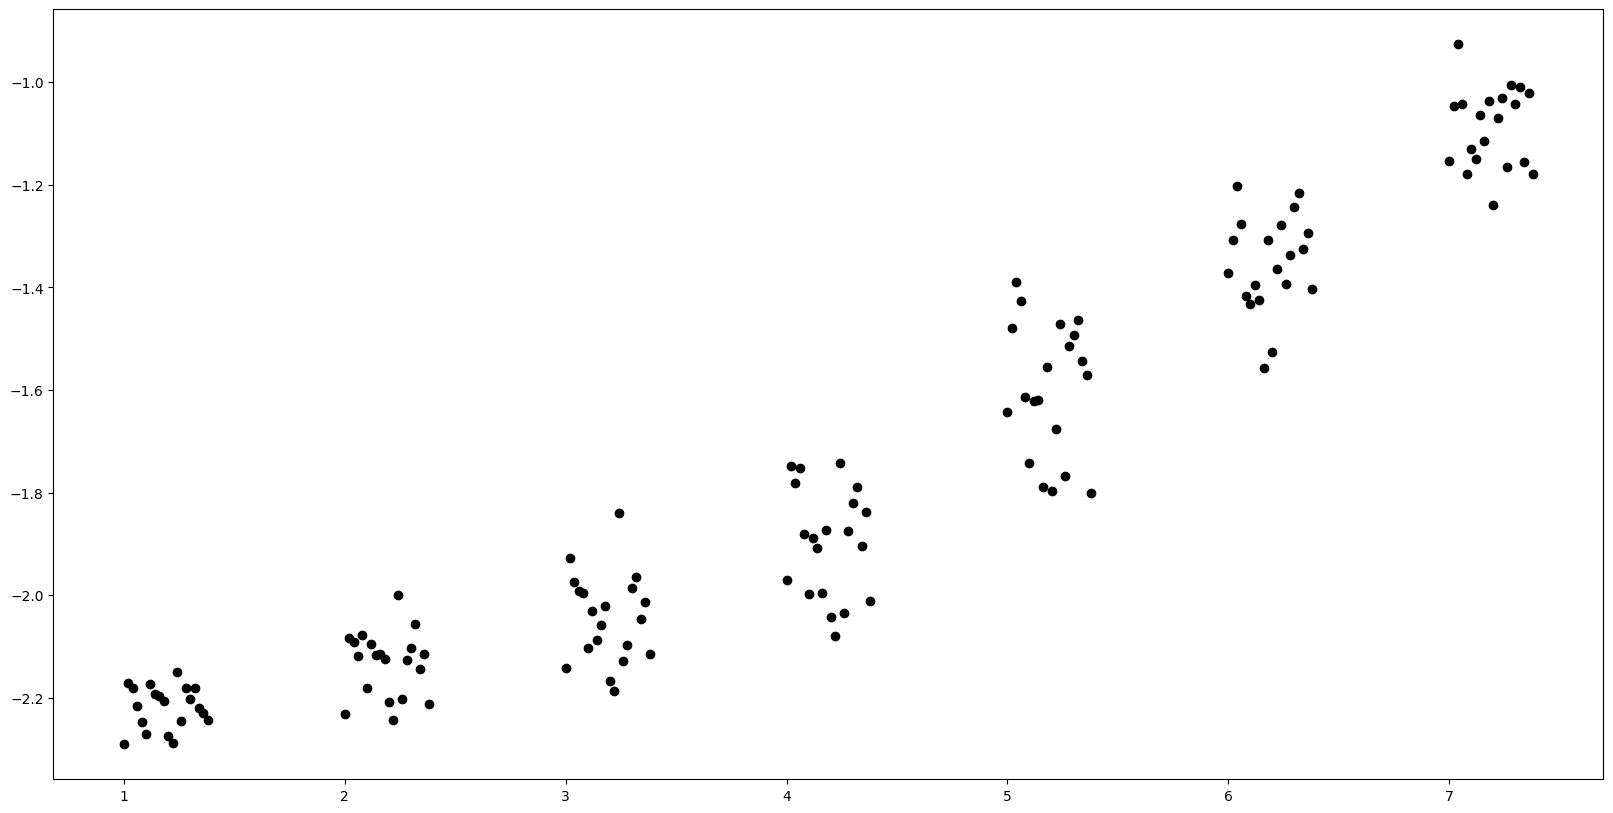

In [ ]:
# We are interested in the lengths of the in-between gradients, so,
# ignoring the first and final layer.
# Let us plot these (logarithmically).
# x-coordinate = {number of weights-layer} + {number of example} * 0.02,
# y_coordinate = log(gradient_length)

pyplot.plot(
    [num_layer + num_example * 0.02
     for num_layer in range(1, grads1.shape[1] - 1)
     for num_example in range(grads1.shape[0])],
    [numpy.log(grads1[num_example, num_layer]) / numpy.log(10)
     for num_layer in range(1, grads1.shape[1] - 1)
     for num_example in range(grads1.shape[0])],
     'ok')
pyplot.show()


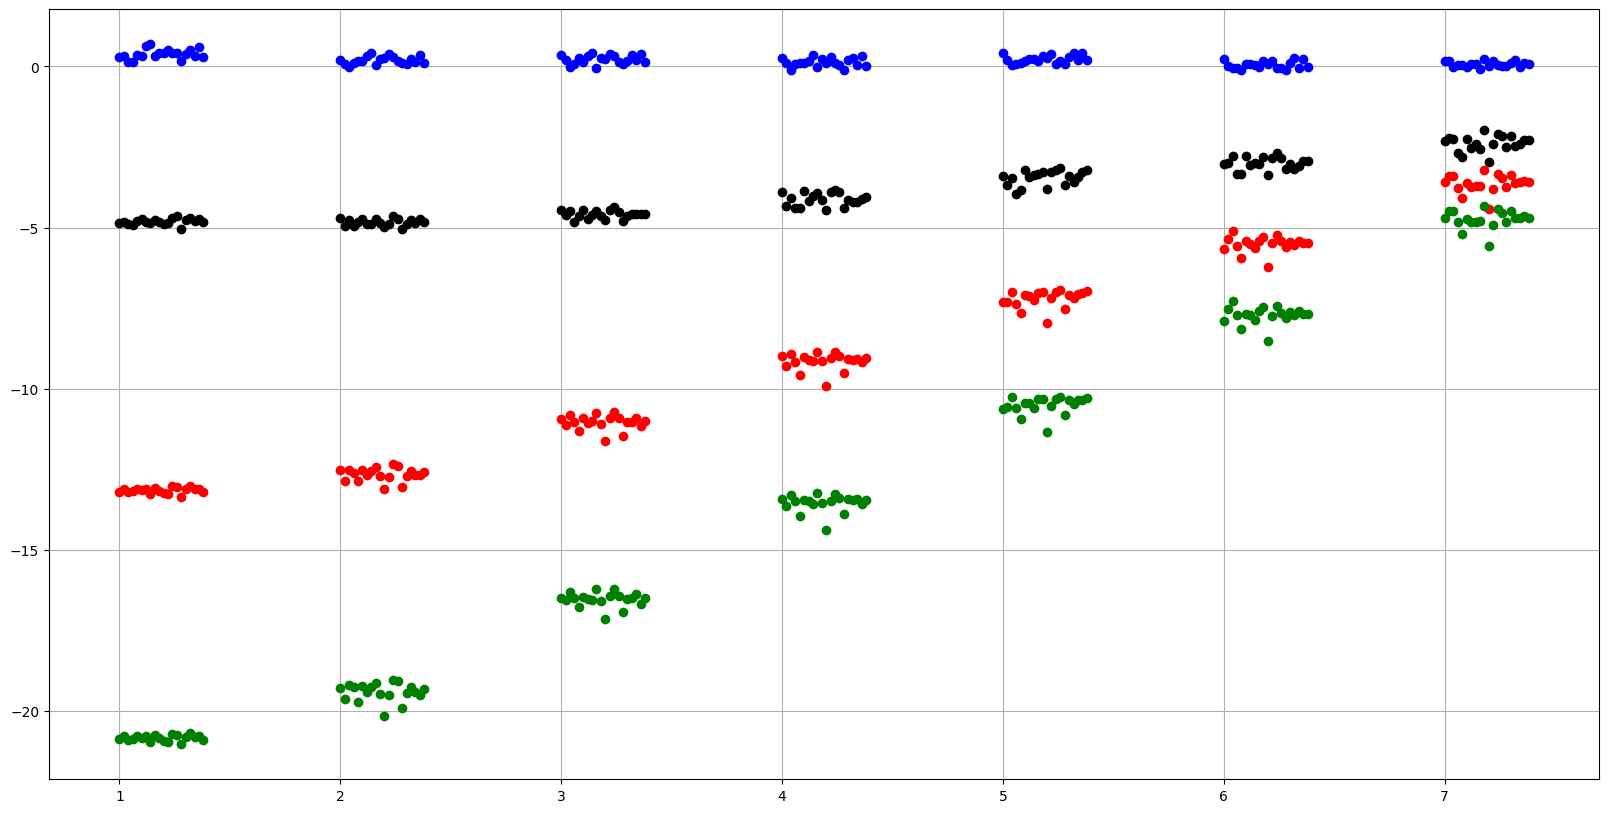

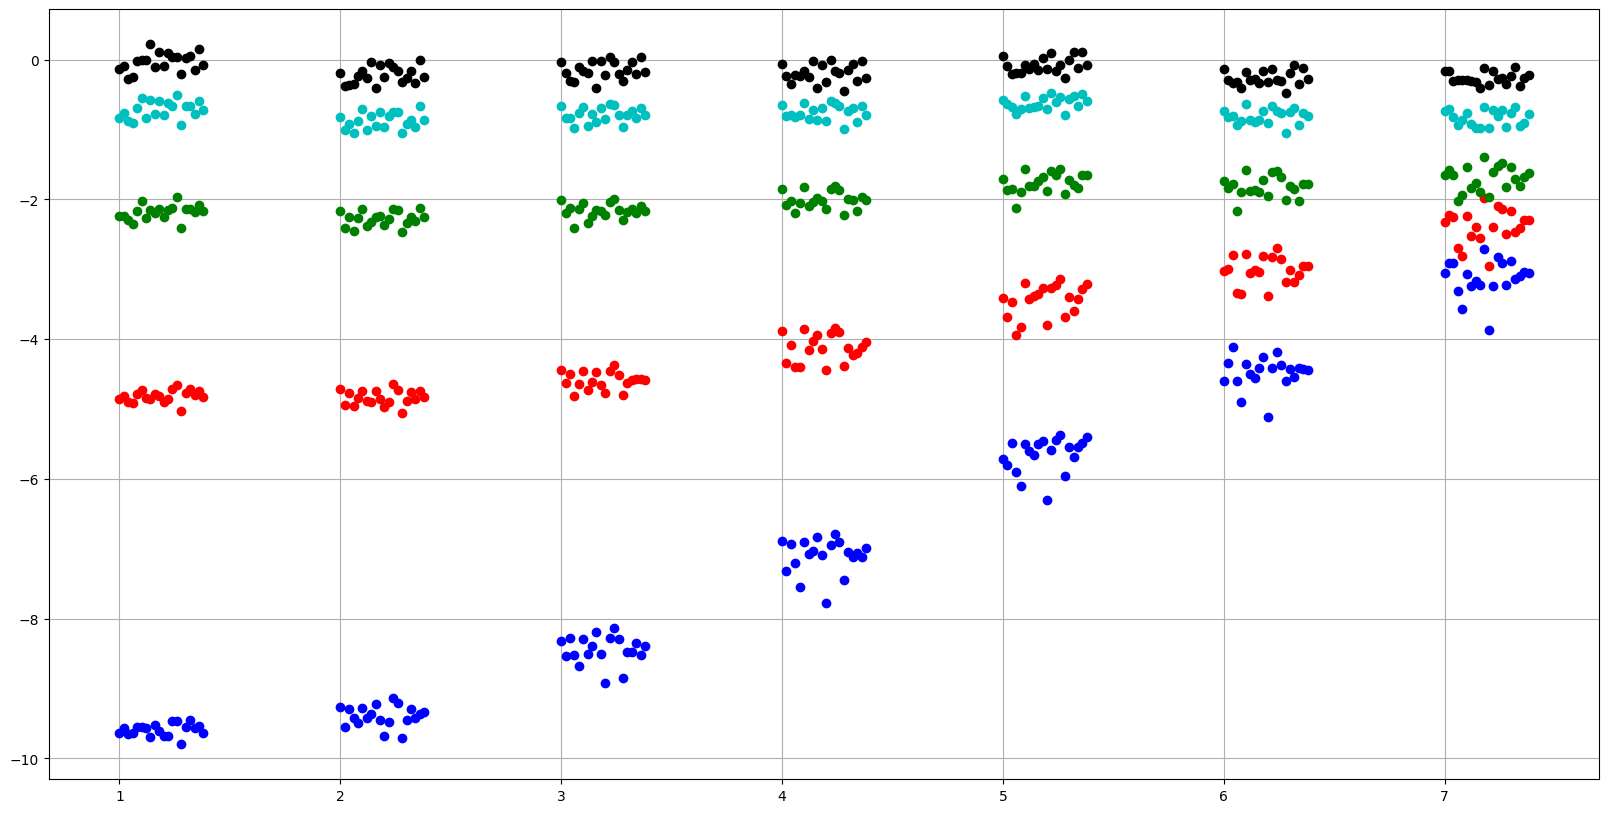

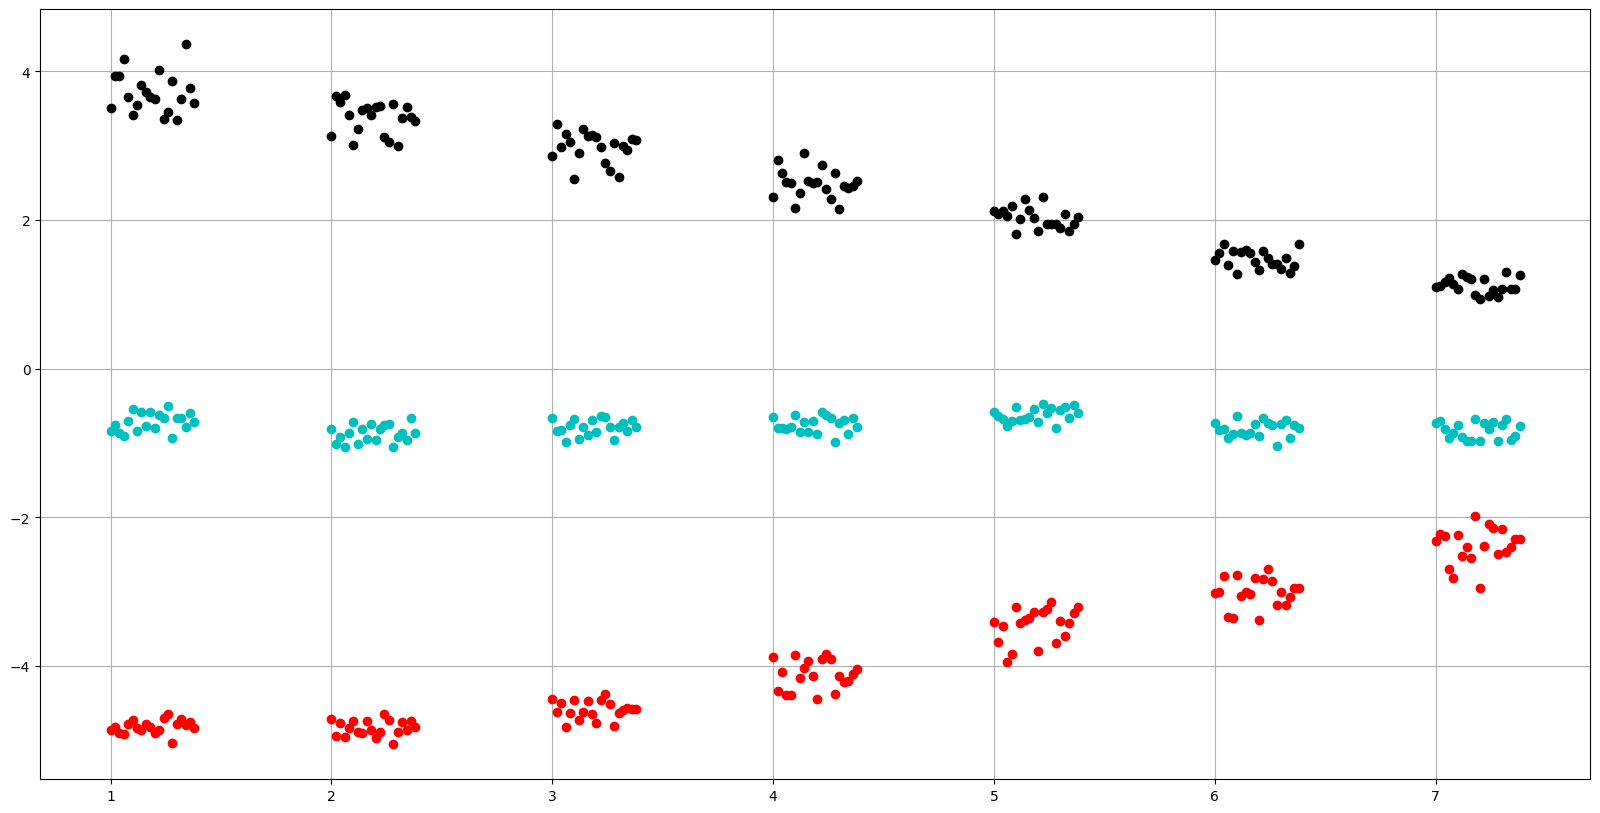

In [ ]:
# This plot shows that, "as we backprop towards earlier layers",
# "the length of the gradient decays", so
# "late layers move a lot in training, but earlier layers only a little".
#
# Let us wrap this up and study this as a function of the weight-
# and bias-noise scaling.

def plot_wb(seq_tag_std_weights_std_biases, num_training_epochs=0, rng_seed=0):
  for plot_tag, std_weights, std_biases in seq_tag_std_weights_std_biases:
    grads, _ = explore_gradients(rng=numpy.random.RandomState(rng_seed),
                                std_weights=std_weights,
                                std_biases=std_biases,
                                num_training_epochs=num_training_epochs)
    #
    pyplot.plot(
      [num_layer + num_example * 0.02
       for num_layer in range(1, grads.shape[1] - 1)
       for num_example in range(grads.shape[0])],
      [numpy.log(grads[num_example, num_layer])
       for num_layer in range(1, grads.shape[1] - 1)
       for num_example in range(grads.shape[0])],
       plot_tag)
  pyplot.grid()
  pyplot.show()


plot_wb([('ok', 0.1, 0.1),
         ('ob', 0.3, 0.1),
         ('or', 0.03, 0.1),
         ('og', 0.01, 0.1),
         ])

plot_wb([('ob', 0.05, 0.1),
         ('or', 0.1, 0.1),
         ('og', 0.15, 0.1),
         ('oc', 0.20, 0.1),
         ('ok', 0.25, 0.1),
         ])

plot_wb([('or', 0.1, 0.1),
         ('oc', 0.20, 0.1),
         ('ok', 1.0, 0.1),
         ])

In [ ]:
# Let us also see what happens after a few epochs.

plot_wb([('or', 0.1, 0.1),
         ('oc', 0.20, 0.1),
         ('ok', 1.0, 0.1),
         ], num_training_epochs=5)


How to interpret this last plot?

For a large amount if initial-weight noise (black), the different batches
(all of size 64) we use to estimate the model-gradient
produce gradients whose lenghts, for the first hidden layer, are "all over the place" (lengths from about from exp(-0.8) to about exp(2.7) or so). We introduced batches to estimate a "roughly OK" low-effort useful-for-training approximation to the model's gradient on the entire training set.

Seeing that gradient-lengths differ by a factor of 30 or so across batches makes the idea that these per-batch gradients would do anything useful look doubtful. It is plausible that we are merely adding noise at this layer in every training step.

Correspondingly, if initial-weight noise is initially very small, we get small activations which take is into the mostly-linear region of our ${\rm tan}^{-1}$ nonlinearity. Every such small-initial-weights layer then "also scales down overall activation by some factor", and it is no surprise that gradient-lengths decay as we backpropagate further away from the result and towards earlier layers.

So, it would be a mistake to assume that "we can start this with a tiny amount of noise, merely to break the symmetry", and then hope for backpropagation to adjust weights to get us something useful even with many layers - remote-from-the-loss layers will move only very little due to this gradient-decay.

Noting that in a fully-connected network with many nodes per layer, "every node is a neighbor of every node from the next layer", i.e. we have a degree of neighbor-connectivity that is higher than what we could get from neighborhood in a 4d embedding, we may wonder whether this situation would be accessible to Mean Field Theory. This has been done in [https://arxiv.org/abs/1611.01232 - "Deep Information Propagation"](https://arxiv.org/abs/1611.01232) -- a (in my view) seminal but wildly under-appreciated paper which likely has not received as much attention as it deserves since most members of the ML community unfortunately do not have a strong background in statistical mechanics. (It should however be noted that there would be more to say about the infinite-width limit of neural networks than what is discussed in that paper.)

A key insight here is that in order to successfully train a deep architecture, we have to pay close attention to how random weight / bias initialization is done.

---

If all this is actually true, then we should be able to train this "mini monster" architecture we have here into a good-quality classifier by using an informed choice of the inner-layer weight standard deviation. If we do this, we still have not really tuned initialization of random parameters for the very first and last layer, but perhaps what we have is good enough...?

We still might have to do some exploration around "finding a good learning rate", though. (I did a tiny bit of manual tweaking to find a good choice.
A useful recipe is to do half-order-of-magnitude adjustments to find the sweet spot between "loss barely moves at all" and "loss often increases rather than decreasing".)

In [ ]:
grads_x, classifier_func_x = explore_gradients(
    rng=numpy.random.RandomState(0),
    std_weights=0.2,
    std_biases=0.1,
    num_training_epochs=200,
    learning_rate=3e-4)


In [ ]:
loss_x, predictions_x, _ = classifier_func_x(
    # Need to use the same normalization function.
    (img0_ourtest - img_offset) / img_stddev,
    labels_1hot_ourtest)

print('Accuracy:',
      numpy.mean([x == y for x, y in zip(
          numpy.argmax(predictions_x, axis=-1),
          numpy.argmax(labels_1hot_ourtest, axis=-1))]))
# Prints:
# Accuracy: 0.95725

Accuracy: 0.95725


So, with just a few minutes of training time on a CPU, we got somewhat reasonable performance (accuracy 95.7%) out of a 8-stacked-nonlinearities (not counting softmax at the end) "deep" neural network by showing to it a collection of 48000 training examples 200 times over.

And we did it all without using any "ML framework". We merely used NumPy in a way we might just as well have used Matlab or Octave instead. If we wanted to, we could translate everything we saw here straightaway to C code. None of the computational steps involved here use any sophisticated processing or algorithms.

Naturally, this is of course still quite far from state-of-the-art. Even pre-DL revolution, error rates well below 1% were achievable for this specific task. Nevertheless, quite a few of the main ideas that allow us to perform even better can be discussed in simpler settings where we do not even have to look at code.

Specifically, these notions are readily explorable via the [https://playground.tensorflow.org/](https://playground.tensorflow.org/) web page:

  * ReLU activation function.
  * L1 and L2 regularization.
  * Tweaking "learning rate".

In our toy classifier, we used ${\rm tan}^{-1}$ as our nonlinearity.
There are quite a few other choices which give about-similar performance. Does the activation function matter? "Yes and No" - in the sense that problematic properties of some particular choice of activation function can often be fixed by other "compensating" design decisions.

Historically, the logistic ("sigmoid") function was popolar in the early neural-networks literature. Here, we have been using a choice that "behaves symmetrically around zero".

It came to quite a surprise that, relative to these choices, the ReLU function ("rectified linear unit"), with its very simple (and scale invariant!) behavior often performs quite a bit better. This is the function $x \mapsto (x+|x|)/2$.
There have been various tweaks to this, such as leaky-relu, and another refinement to this idea was ELU (replacing the negative side with an exponential).

A particularly interesting choice has been presented in [https://arxiv.org/abs/1706.02515v5 - Self-normalizing neural networks](https://arxiv.org/abs/1706.02515v5): This choice tries to "by design" (under reasonable assumptions) drive activations towards a "zero mean, unit variance" fixed point. However, there is a lot of literature of the "This paper demonstrates that my nonlinearity performs better than yours" type. Pragmatically, ReLU still is a good default choice for a first shot at getting useful results.

## Addendum: Thoughts on universal approximation theorems

(This was not covered on the IMPRS course given at the Albert Einstein Institute in 2022, and expresses some views of the present author that may not have the status of being consensus in the ML community.)

With neural networks, two obvious questions are: "Is some particular aspect of interest 'learnable' from the set of examples we have available" (it may well be that we would need many more examples to be sufficiently dense in space to make the aspect we are interested in approximable by our model), and "does our chosen architecture perhaps not permit learning some functions"? Clearly, a linear model would fail to learn the behavior of an exclusive-or logic gate. In general, we have "[Universal Approximation Theorems](https://en.wikipedia.org/wiki/Universal_approximation_theorem)" that basically state that for common popular Deep Neural Network architectures, they can learn to approximate every "reasonable" function, given sufficient capacity. (Clearly, we would however not expect any finite-size model with a simple architecture to be able to train on examples for `label = sin(1/feature)` in such a way that it would produce a main characteristic of this relation - infinitely many zeroes.) With ReLU units, this is quite intuitive - as a function of the activations that get summed and then put into a ReLU unit, this unit is linear on one side of a hyperplane and zero on the other. This means two things: First, for any given point not on any hyperplane where a ReLU starts to activate (which are finitely many, so this is a set of measure zero), the output is linear in the inputs. In a sense, a 100-layers deep ReLU network, when observed locally, "collapses to a 1-layer linear model". Second, by summing such ReLU functions - and taking ReLU outputs as inputs of other ReLU units, we effectively partition up feature-space in a mosaic of polyhedral cells (some of which will extend to infinity). Clearly, given sufficient capacity, every function that we can think of as being in some sense approximable by a continuous function that is piecewise-affine on mosaic cells is then "learnable" by a ReLU network with sufficient capacity.

This however does not mean that it would not make sense to look deeper into the general structure of data-processing inside neural networks. One interesting aspect is that we are only discussing one-dimensional nonlinearities, so there is a hidden claim here that every higher-dimensional non-linear function can be approximated by only one-dimensional nonlinearities and addition as the only binary operation (i.e. operation which "combines" data). This is true, and commonly known as the [Kolmogorov-Arnold Representation Theorem](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Arnold_representation_theorem) (which in itself has an interesting back story and relation to Hilbert's 13th problem). There is however a problem which is especially relevant in physics-related applications where problems often have some interesting symmetry (such as: rotational symmetry).

The issue is best illustrated by example: Suppose we wanted to learn computing the determinant of a real $5\times 5$-matrix. This is a conceptually rather simple mapping from 25 real input parameters (matrix elements) to a 1-dimensional output (the determinant) - clearly, we can write this as a 5th-degree homogeneous polynomial with $5!=120$ summands. How would this be learned? Ultimately, this would involve learning to multiply two numbers (in many places), but since we only ever combine different internal activations by adding them, multiplication of two positive numbers would have to be synthesized from a learned approximation to a logarithm, learned independently for both inputs, then summing, followed by a learned approximation to an exponential. For signed quantities, this then becomes even more complicated. Intuitively, it is clear that "learning to compute a determinant" will be possible in principle, but one would also expect that having to learn all these - from the perspective of a neural network "unnatural" - multiplication operations can easily make the size of the training set that would be required to properly learn computing a determinant (and hence, also training time) prohibitively large. The determinant is of course only one example of a polynomial geometric invariant, and the story would be similar for many a problem where we would expect learning to be able to "discover" that some derived quantity such as - say - Mandelstam variables might be useful to predict an outcome. One possible approach would be to design multiplication into the architecture, as is done with Sigma-Pi networks. Overall, these are one of many "fringe architectures" that can be employed to address very specific problems. A perhaps even more fringe (but, in the present author's view, useful) idea is to take this a step further and try to use an architecture which like a Sigma-Pi network already has an inherent concept of multiplication, but avoids much of the need for architecture-search - simply by going from a one-dimensional nonlinearity to using matrix exponentiation as a nonlinearity - our paper [https://arxiv.org/abs/2008.03936 - Intelligent Matrix Exponentiation](https://arxiv.org/abs/2008.03936) characterizes properties of this nonlinearity (and in particular shows that this is indeed able to learn determinants, unlike conventional architectures - as participants are invited to verify by trying), but deliberately not going as deep into Lie group theory as one could do here, given the intended ML audience.